In [1]:
from entities import *
from constants import TEAMS_DATA, STAT_EFFECTS, POSSESSIONS_STD_DEV
from simulations import *

import pickle
import numpy as np
import pandas as pd

In [2]:
with open(TEAMS_DATA, 'rb') as f:
    teams = pickle.load(f)

with open(STAT_EFFECTS, 'rb') as f:
    stats = pickle.load(f)

In [3]:
az = teams['Arizona']
af = teams['Air Force']

In [4]:
from IPython.display import clear_output
from tqdm import tqdm, trange

In [23]:
def parse_game_log(log):
    
    team_1_log = log[0]
    team_2_log = log[1]

    team_1_players = list(team_1_log.keys())
    team_2_players = list(team_2_log.keys())
    players = [team_1_players, team_2_players]

    event_log = {}
    for player in (team_1_players + team_2_players):
        event_log[player] = {}

    for i, team_log in enumerate([team_1_log, team_2_log]):
        for player in players[i]:
            for event, count  in team_log[player][2].items():
                if not event_log.get(player).get(event):
                    event_log[player][event] = count
                else:
                    event_log[player][event] += count

    return event_log


from collections import Counter
import pandas as pd
from tqdm import trange


def simulate_n_games(team_1, team_2, n: int, summary=False, viz=False):
    print(f'Simulating Game: {team_1.name} vs. {team_2.name}')

    team_1_win_counter = 0
    team_2_win_counter = 0
    game_results = {
        team_1.name: [],
        team_2.name: []
    }
    
    total_stats_log = {}
    player_games_count = Counter() # Specifically for "Games Played"

    for i in trange(n):
        game = simulate_game(team_1, team_2)
        
        # 2. Append Scores for statistical analysis
        # We match the score to the correct team name list
        if game['Winner'] == team_1.name:
            team_1_win_counter += 1
            game_results[team_1.name].append(game['Winner Score'])
            game_results[team_2.name].append(game['Loser Score'])
        else:
            team_2_win_counter += 1
            game_results[team_2.name].append(game['Winner Score'])
            game_results[team_1.name].append(game['Loser Score'])

        # 3. Parse and Update Stats
        game_log = parse_game_log(game['Game Log'])

        for player, stats in game_log.items():
            # Track participation
            player_games_count[player] += 1
            
            # Update cumulative stats
            if player not in total_stats_log:
                total_stats_log[player] = Counter(stats)
            else:
                total_stats_log[player].update(stats)

    # Final Processing
    team_1_players = list(team_1.df.index)

    df = pd.DataFrame(total_stats_log).T.fillna(0)
    df['Games Played'] = df.index.map(player_games_count)
    df['Team'] = [team_1.name if p in team_1_players else team_2.name for p in list(df.index)]

    # Converting numbers in the dataframe to integers
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col]).astype(int)

    overall_winner = team_1.name if team_1_win_counter > team_2_win_counter else team_2.name
    overall_loser = team_1.name if team_1_win_counter < team_2_win_counter else team_2.name
    record = f'{team_1.name}: {team_1_win_counter} - {team_2_win_counter} :{team_2.name}'

    print(f'{team_1.name} vs. {team_2.name} Complete!')

    return {'Winner': overall_winner,
             'Loser': overall_loser, 
             'Contributions': df, 
             'Scores': game_results, 
             'Record': record
            }

In [53]:
test = simulate_n_games(teams['Kansas'], teams['Connecticut'], 500)

Simulating Game: Kansas vs. Connecticut


100%|██████████| 500/500 [00:12<00:00, 40.89it/s]

Kansas vs. Connecticut Complete!


In [54]:
test['Record']

'Kansas: 239 - 261 :Connecticut'

In [55]:
test['Contributions']

,2P,3P,BLK,STL,TOV,ORB,DRB,PF,Games Played,Team
Elmarko Jackson,539,404,340,208,681,75,1154,1154,282,Kansas
Flory Bidunga,3202,0,1283,267,935,1390,3261,1229,398,Kansas
Jamari McDowell,66,736,139,397,477,139,1014,815,296,Kansas
Kohl Rosario,749,617,141,283,546,546,688,1235,301,Kansas
Tre White,1377,692,209,314,1073,1178,2592,1335,389,Kansas
Alex Karaban,1503,1035,609,464,348,929,1858,1190,432,Connecticut
Braylon Mullins,999,400,0,102,297,297,697,1097,152,Connecticut
Eric Reibe,2661,203,882,203,542,950,2194,1425,337,Connecticut
Jaylin Stewart,948,571,376,501,626,501,2031,1278,374,Connecticut
Solomon Ball,1664,1144,162,459,810,405,1486,1080,402,Connecticut


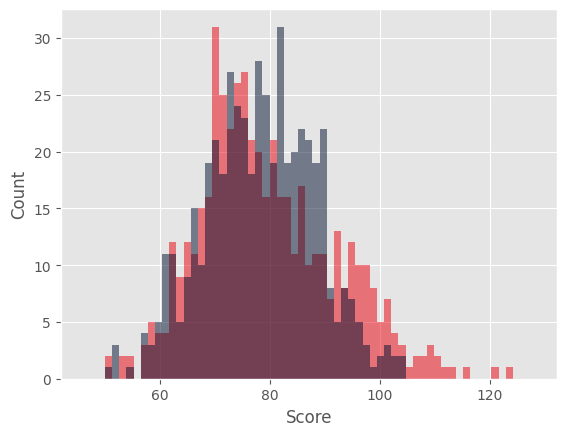

In [56]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

kansas = test['Scores']['Kansas']
uconn = test['Scores']['Connecticut']

min_score = min(kansas + uconn)
max_score = max(kansas + uconn)

bins = np.linspace(min_score-5, max_score+5, 64)

plt.hist(kansas, bins=bins, color='#e8000d', alpha=0.5)
plt.hist(uconn, bins=bins, color='#000E2F', alpha=0.5)
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()